In [1]:
import pandas as pd
from textblob import TextBlob
import math
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_normalized_polarity_price = pd.read_csv("normalized_polarity_price.csv")
df_normalized_polarity_price.date = pd.to_datetime(df_normalized_polarity_price.date)

In [3]:
df_normalized_polarity_price.head()

,date,normalized_polarity,normalized_price
0,2011-03-29,0.820735,0.896216
1,2011-03-30,0.789064,0.890023
2,2011-03-31,0.783535,0.917431
3,2011-04-01,0.806864,0.933028
4,2011-04-04,0.923509,0.939794


In [4]:
lag_dict = {'normalized_polarity':4,'normalized_price':2} 

In [5]:
frame = []
series_index=1
for each_type in lag_dict:
    lag = lag_dict[each_type]
    ts = df_normalized_polarity_price[each_type].tolist()
    df = pd.DataFrame(ts)
    n_vars = 1 if type(ts) is list else ts.shape[1]
    cols,names = list(),list()
    # input sq(t-n,...,t-1)
    for i in range(lag,0,-1):
        cols.append(df.shift(i))
        names += [('(t-%d)%d' % (i,j+1)) for j in range(n_vars)]
    # forecast sq(t,t+1,..,t+n)
    for i in range(0,1):
        cols.append(df.shift(-i))
        if i==0:
            names += [('(t)%d' % (j+1)) for j in range(n_vars)]
        else:
            names += [('(t+%d)' % (j+1)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    colList = agg.columns
    length = len(colList)
    agg.columns = ['var'+str(series_index)+'(t-%d)' %(length-1-i) for i in range(length)]
    series_index+=1
    frame.append(agg)

agg1 = pd.concat(frame,axis=1)
agg1.dropna(inplace=True)

for name in agg1.columns:
    if name != 'var2(t-0)':
        if '(t-0)' in name:
            agg1 = agg1.drop([name],axis=1)

In [6]:
agg1

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var2(t-2),var2(t-1),var2(t-0)
4,0.820735,0.789064,0.783535,0.806864,0.917431,0.933028,0.939794
5,0.789064,0.783535,0.806864,0.923509,0.933028,0.939794,0.936124
6,0.783535,0.806864,0.923509,0.838991,0.939794,0.936124,0.942546
7,0.806864,0.923509,0.838991,0.849925,0.936124,0.942546,0.959060
8,0.923509,0.838991,0.849925,0.861313,0.942546,0.959060,0.987156
...,...,...,...,...,...,...,...
1988,0.735858,0.735692,0.725664,0.739899,0.371560,0.370642,0.377294
1989,0.735692,0.725664,0.739899,0.731557,0.370642,0.377294,0.377638
1990,0.725664,0.739899,0.731557,0.776877,0.377294,0.377638,0.389106
1991,0.739899,0.731557,0.776877,0.761152,0.377638,0.389106,0.387500


In [7]:
values = agg1.values
# ensure all data is float
values = values.astype('float32')
values.shape

(1989, 7)

In [8]:

#Filling Nan with mean
numFeat = np.shape(values)[1]
for i in range(numFeat):
    meanVal = np.mean(values[np.nonzero(~np.isnan(values[:,i]))[0],i]) 
    #values that are not NaN (a number)
    values[np.nonzero(np.isnan(values[:,i]))[0],i] = meanVal

In [47]:
# split into train and test sets
size = int(len(values)*2/3)
train = values[:size, :]
test = values[size:, :]

# split into input and outputs
train_2X, train_y = train[:, :-1], train[:, -1]
test_2X, test_y = test[:, :-1], test[:, -1]


#Data format to be used in RFE model
ta_X = train_2X
ta_y = train_y
te_X = test_2X
real_y = test_y 

In [48]:
te_X.shape

(663, 6)

# preprocessing done, now start regression

In [49]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor  
ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(splitter="random",
                                                                max_depth=1,
                                                                min_samples_split=3),
                        n_estimators=30,learning_rate=0.01)

model_list = [ada]

In [50]:
#define RMSE
# l1-true,l2-false
def RMSE(l1,l2):
    length = len(l1)
    sum = 0
    for i in range(length):
        sum = sum + np.square(l1[i]-l2[i])
    return math.sqrt(sum/length)
#define MAE
def MAE(l1,l2):
    n = len(l1)
    l1 = np.array(l1)
    l2 = np.array(l2)
    mae = sum(np.abs(l1-l2))/n
    return mae
#def MAPE
def MAPE(l1,l2):
    n = len(l1)
    l1 = np.array(l1)
    l2 = np.array(l2)
    for i in range(len(l1)):
        if l1[i] == 0:
            l1[i] = 0.01
    mape = sum(np.abs((l1-l2)/l1))/n
    return mape

In [51]:
rmselist = []
maelist = []
mapelist = []
size = int(len(values)*(2/3))
agg1
df_integrated=agg1
for num_of_feature in range(2,len(df_integrated.columns)): # exclude t-0
    rfe = RFE(DecisionTreeRegressor(), num_of_feature)           
    fit = rfe.fit(ta_X, ta_y)
    feature_choose_list = fit.support_
    ixList = []
    choisen_train_x = []
    choisen_test_x = []
    for i in range(len(feature_choose_list)):
        #print(feature_choose_list[i])
        if feature_choose_list[i] == True: # numpy._bool
            print(f"{i} is choisen")
            ixList.append(i)
            choisen_train_x.append(ta_X[:,i])
            choisen_test_x.append(te_X[:,i])

    choisen_train_x = np.array(choisen_train_x).T
    choisen_test_x = np.array(choisen_test_x).T

    y_pred = []
    

    ada.fit(choisen_train_x, ta_y)
    y_pred=ada.predict(choisen_test_x)
    rmse = RMSE(list(real_y),y_pred)
    rmselist.append(rmse)
    mae = MAE(list(real_y),y_pred)
    maelist.append(mae)
    mape = MAPE(list(real_y),y_pred)
    mapelist.append(mape)
    print('num of feature is {},rmse={},mae={},mape={}'.format(num_of_feature,rmse,mae,mape))

D:\Program Files\Anaconda3\envs\ds-env\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
D:\Program Files\Anaconda3\envs\ds-env\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


4 is choisen
5 is choisen
num of feature is 2,rmse=0.10934043699550035,mae=0.08882342939498664,mape=0.2328184195910339
3 is choisen
4 is choisen
5 is choisen
num of feature is 3,rmse=0.11632886925229148,mae=0.08785280962431809,mape=0.22901308253874642
0 is choisen
3 is choisen
4 is choisen
5 is choisen
num of feature is 4,rmse=0.07127916510789913,mae=0.055769382686428885,mape=0.16263555923983944
0 is choisen
2 is choisen
3 is choisen
4 is choisen
5 is choisen
num of feature is 5,rmse=0.10671044833105937,mae=0.08546499737473016,mape=0.22525422261512246
0 is choisen
1 is choisen
2 is choisen
3 is choisen
4 is choisen
5 is choisen


D:\Program Files\Anaconda3\envs\ds-env\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
D:\Program Files\Anaconda3\envs\ds-env\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
D:\Program Files\Anaconda3\envs\ds-env\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=6 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


num of feature is 6,rmse=0.09888095379367275,mae=0.07823205209637299,mape=0.20261370439355889


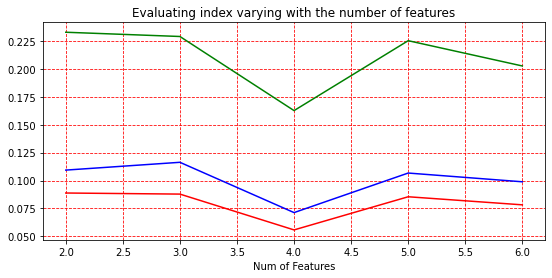

In [52]:
#plot    
plt.figure(figsize=(9, 4))
plt.grid(c='r',ls='--')
plt.plot(range(2,len(rmselist)+2),rmselist,'b',label='rmse')
plt.plot(range(2,len(maelist)+2),maelist,'r',label='mae')
plt.plot(range(2,len(mapelist)+2),mapelist,'g',label='mape')
plt.title('Evaluating index varying with the number of features')
plt.xlabel('Num of Features')
plt.show() 

In [53]:
rmselist = np.array(rmselist)
maelist = np.array(maelist)
mapelist = np.array(mapelist)
newlist = (rmselist+maelist+mapelist)/3
newlist = list(newlist)
index = newlist.index(min(newlist))
num = index+2 # statring from 2 above, +2 back to count

In [54]:
print('step = 0, the rmse, mae and mape are %.2f, %.2f, %.2f respectively:'% (rmselist[index],maelist[index],mapelist[index]))

step = 0, the rmse, mae and mape are 0.07, 0.06, 0.16 respectively:


# found optimal number of features to use, now go for real run

In [55]:
num_of_feature=num
rfe = RFE(DecisionTreeRegressor(), num_of_feature)           
fit = rfe.fit(ta_X, ta_y)
feature_choose_list = fit.support_


choisen_train_x = []
choisen_test_x = []
choisen_values = []
for i in range(len(feature_choose_list)):
    #print(feature_choose_list[i])
    if feature_choose_list[i] == True: # numpy._bool
        print(f"{i} is choisen")
        ixList.append(i)
        choisen_train_x.append(ta_X[:,i])
        choisen_test_x.append(te_X[:,i])
        choisen_values.append(values[:,i])
choisen_train_x = np.array(choisen_train_x).T
choisen_test_x = np.array(choisen_test_x).T
choisen_values = np.array(choisen_values).T

from tqdm import tqdm
y_pred_h1=[]
step = 1
for j in tqdm(range(size, len(values))): 
    y_pred_h1.append(Model.predict(choisen_values[:,:-1][j-step, :].reshape((1, -1)))[0])

rmse_h1 = RMSE(list(real_y),y_pred_h1)
mae_h1 = MAE(list(real_y),y_pred_h1)
mape_h1 = MAPE(list(real_y),y_pred_h1)

y_pred_h2=[]
step = 2
for j in tqdm(range(size, len(values))): 
    y_pred_h2.append(Model.predict(choisen_values[:,:-1][j-step, :].reshape((1, -1)))[0])

rmse_h2 = RMSE(list(real_y),y_pred_h2)
mae_h2 = MAE(list(real_y),y_pred_h2)
mape_h2 = MAPE(list(real_y),y_pred_h2)
y_pred_h3=[]
step = 3
for j in tqdm(range(size, len(values))): 
    y_pred_h3.append(Model.predict(choisen_values[:,:-1][j-step, :].reshape((1, -1)))[0])
rmse_h3 = RMSE(list(real_y),y_pred_h3)
mae_h3 = MAE(list(real_y ),y_pred_h3)
mape_h3 = MAPE(list(real_y ),y_pred_h3)

0 is choisen
3 is choisen
4 is choisen
5 is choisen


D:\Program Files\Anaconda3\envs\ds-env\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [92]:
print(f"rmse_h1={rmse_h1}\n mae_h1 ={mae_h1}\n mape_h1 ={mape_h1}\n")
print(f"rmse_h2={rmse_h2}\n mae_h2 ={mae_h2}\n mape_h2 ={mape_h2}\n")
print(f"rmse_h3={rmse_h3}\n mae_h3 ={mae_h3}\n mape_h3 ={mape_h3}\n")

rmse_h1=0.08225587921793555
 mae_h1 =0.06849137853940733
 mape_h1 =0.187346841255404

rmse_h2=0.08339155661338409
 mae_h2 =0.06909682675349257
 mape_h2 =0.1884582894005379

rmse_h3=0.08437654876624838
 mae_h3 =0.06953533922440043
 mape_h3 =0.18937126889421713

